# Read data



Ce notebook lit le fichier `btc_hourly_ohclv_ta.csv` depuis le dossier courant.



- Si tu vois une erreur `file.exists` : vérifie que le *Working Directory* de Jupyter est bien `D:\projet   R`.


In [7]:
# Read data from CSV (relative path)

csv_path <- "btc_hourly_ohclv_ta.csv"

stopifnot(file.exists(csv_path))



# Prefer readr if installed; fallback to data.table; then base

read_csv_safely <- function(path) {

  if (requireNamespace("readr", quietly = TRUE)) {

    return(readr::read_csv(path, show_col_types = FALSE))

  }

  if (requireNamespace("data.table", quietly = TRUE)) {

    return(data.table::fread(path))

  }

  read.csv(path, stringsAsFactors = FALSE)

}



df <- read_csv_safely(csv_path)



cat("Rows:", nrow(df), "\n")

cat("Cols:", ncol(df), "\n\n")

cat("Column names:\n")

print(names(df))



cat("\nHead (first 10 rows):\n")

print(utils::head(df, 10))



cat("\nStructure:\n")

str(df)


Rows: 95925 
Cols: 28 

Column names:
 [1] "UNIX_TIMESTAMP"       "DATETIME"             "OPEN"                
 [4] "HIGH"                 "CLOSE"                "LOW"                 
 [7] "VOLUME"               "SMA_20"               "EMA_12"              
[10] "EMA_26"               "MACD"                 "MACD_SIGNAL"         
[13] "MACD_DIFF"            "RSI"                  "BB_HIGH"             
[16] "BB_LOW"               "BB_WIDTH"             "STOCH_K"             
[19] "STOCH_D"              "VOLUME_SMA"           "MFI"                 
[22] "ATR"                  "PRICE_CHANGE"         "HIGH_LOW_RATIO"      
[25] "CLOSE_OPEN_RATIO"     "VOLATILITY_30D"       "PRICE_VOLATILITY_30D"
[28] "HL_VOLATILITY_30D"   

Head (first 10 rows):
# A tibble: 10 × 28
   UNIX_TIMESTAMP DATETIME             OPEN  HIGH CLOSE   LOW  VOLUME SMA_20
            <dbl> <dttm>              <dbl> <dbl> <dbl> <dbl>   <dbl>  <dbl>
 1     1418623200 2014-12-15 06:00:00  350.  350.  350.  349. 287499.  

---

⚠️ **Ordre d'exécution important**

1. Exécute d'abord la cellule 2 (lecture CSV `df`)
2. Puis la cellule 3 (installation + chargement des packages)
3. Enfin la cellule 4 (prétraitement `dt`)
4. Et ensuite les actes 1-7 dans l'ordre

Si tu vois `Error: aucun package nommé 'TTR' n'est trouvé`, c'est que la cellule 3 n'a pas été exécutée (ou a échoué). Relance-la.

---


In [8]:
# 0) Packages (chargement des libs nécessaires)
options(repos = c(CRAN = "https://cloud.r-project.org"))

ensure_pkgs <- function(pkgs) {
  installed <- rownames(installed.packages())
  missing <- setdiff(pkgs, installed)
  if (length(missing) > 0) {
    message("📦 Installation des packages manquants: ", paste(missing, collapse = ", "))
    install.packages(missing)
  } else {
    message("✅ Tous les packages sont déjà installés.")
  }
  invisible(TRUE)
}

pkgs <- c("tidyverse", "lubridate", "TTR", "zoo", "patchwork", "DT", "scales")
ensure_pkgs(pkgs)

suppressPackageStartupMessages({
  library(tidyverse)
  library(lubridate)
  library(TTR)
  library(zoo)
  library(patchwork)
  library(DT)
  library(scales)
})

cat("✅ Packages chargés avec succès:\n")
cat("  - tidyverse (dplyr, ggplot2, readr, tidyr)\n")
cat("  - lubridate (parsing dates)\n")
cat("  - TTR (indicateurs techniques)\n")
cat("  - zoo (rolling windows)\n")
cat("  - patchwork (composition de plots)\n")
cat("  - DT (tables interactives)\n")
cat("  - scales (formatage axes)\n")


✅ Tous les packages sont déjà installés.



✅ Packages chargés avec succès:
  - tidyverse (dplyr, ggplot2, readr, tidyr)
  - lubridate (parsing dates)
  - TTR (indicateurs techniques)
  - zoo (rolling windows)
  - patchwork (composition de plots)
  - DT (tables interactives)
  - scales (formatage axes)


In [9]:
# 1) Prétraitement: standardiser les colonnes et créer des features

stopifnot(exists("df"))



# Trouver les colonnes clés (insensible à la casse)

cn <- names(df)

cn_lc <- tolower(cn)

find_col <- function(cands) {

  i <- which(cn_lc %in% tolower(cands))

  if (length(i) == 0) return(NA_integer_)

  i[1]

}



idx_time   <- find_col(c("datetime","date","timestamp","time","open_time","close_time"))

idx_open   <- find_col(c("open"))

idx_high   <- find_col(c("high"))

idx_low    <- find_col(c("low"))

idx_close  <- find_col(c("close","close_price","closing_price"))

idx_volume <- find_col(c("volume","vol","quote_volume"))



dt <- as_tibble(df)

if (!is.na(idx_time)) {

  time_raw <- df[[idx_time]]

  if (!inherits(time_raw, "POSIXct")) {

    # Essayer plusieurs parsers

    tt <- suppressWarnings(lubridate::ymd_hms(time_raw, tz = "UTC"))

    if (all(is.na(tt))) tt <- suppressWarnings(lubridate::ymd_hm(time_raw, tz = "UTC"))

    if (all(is.na(tt))) tt <- suppressWarnings(lubridate::parse_date_time(time_raw, orders = c("Ymd HMS","Ymd HM","Y-m-d H:M:S","dmy HMS","dmy HM","ymd"), tz = "UTC"))

    time_parsed <- tt

  } else {

    time_parsed <- time_raw

  }

  dt <- dt %>% mutate(datetime = time_parsed)

}

if (!is.na(idx_open))   dt <- dt %>% mutate(open  = suppressWarnings(as.numeric(df[[idx_open]])))

if (!is.na(idx_high))   dt <- dt %>% mutate(high  = suppressWarnings(as.numeric(df[[idx_high]])))

if (!is.na(idx_low))    dt <- dt %>% mutate(low   = suppressWarnings(as.numeric(df[[idx_low]])))

if (!is.na(idx_close))  dt <- dt %>% mutate(close = suppressWarnings(as.numeric(df[[idx_close]])))

if (!is.na(idx_volume)) dt <- dt %>% mutate(volume = suppressWarnings(as.numeric(df[[idx_volume]])))



if ("datetime" %in% names(dt)) dt <- dt %>% arrange(datetime)



# Fenêtres

window_short <- 20L

window_fast  <- 12L

window_slow  <- 26L

window_sig   <- 9L

window_vol30d <- 720L  # 30j * 24h



# Returns (PRICE_CHANGE) à partir de close

if ("close" %in% names(dt)) {

  dt <- dt %>% mutate(PRICE_CHANGE = close/lag(close) - 1)

}



# ATR (n=14) si OHLC disponibles

if (all(c("high","low","close") %in% names(dt))) {

  atr_df <- TTR::ATR(cbind(dt$high, dt$low, dt$close), n = 14)

  dt$ATR <- as.numeric(atr_df[,"atr"])

}



# RSI (n=14)

if ("close" %in% names(dt)) {

  dt$RSI <- as.numeric(TTR::RSI(dt$close, n = 14))

}



# SMA/EMA, MACD

if ("close" %in% names(dt)) {

  dt$SMA_20 <- as.numeric(TTR::SMA(dt$close, n = window_short))

  dt$EMA_12 <- as.numeric(TTR::EMA(dt$close, n = window_fast))

  dt$EMA_26 <- as.numeric(TTR::EMA(dt$close, n = window_slow))

  macd <- TTR::MACD(dt$close, nFast = window_fast, nSlow = window_slow, nSig = window_sig)

  dt$MACD <- as.numeric(macd[ ,"macd"]) 

  dt$MACD_SIGNAL <- as.numeric(macd[ ,"signal"]) 

}



# Rolling volatility sur 30 jours (écart-type des returns)

if ("PRICE_CHANGE" %in% names(dt)) {

  dt$VOLATILITY_30D <- as.numeric(zoo::rollapply(dt$PRICE_CHANGE, width = window_vol30d, FUN = sd, align = "right", fill = NA, na.rm = TRUE))

  dt$PRICE_VOLATILITY_30D <- dt$VOLATILITY_30D

}



# VOLUME_SMA

if ("volume" %in% names(dt)) {

  dt$VOLUME_SMA <- as.numeric(TTR::SMA(dt$volume, n = window_short))

}



# Ratios

if (all(c("high","low","close") %in% names(dt))) {

  dt$HIGH_LOW_RATIO <- (dt$high - dt$low) / dt$close

}

if (all(c("close","open") %in% names(dt))) {

  dt$CLOSE_OPEN_RATIO <- dt$close/dt$open - 1

}



# Stochastique

if (all(c("high","low","close") %in% names(dt))) {

  st <- suppressWarnings(TTR::stoch(cbind(dt$high, dt$low, dt$close)))

  if (!is.null(st)) {

    dt$STOCH_K <- as.numeric(st[,"fastK"]) * 100

    dt$STOCH_D <- as.numeric(st[,"fastD"]) * 100

  }

}



cat("Prétraitement terminé. Colonnes disponibles:\n")

print(intersect(names(dt), c("datetime","open","high","low","close","volume","PRICE_CHANGE","ATR","RSI","SMA_20","EMA_12","EMA_26","MACD","MACD_SIGNAL","VOLATILITY_30D","PRICE_VOLATILITY_30D","VOLUME_SMA","HIGH_LOW_RATIO","CLOSE_OPEN_RATIO","STOCH_K","STOCH_D")))


Prétraitement terminé. Colonnes disponibles:
 [1] "SMA_20"               "EMA_12"               "EMA_26"              
 [4] "MACD"                 "MACD_SIGNAL"          "RSI"                 
 [7] "STOCH_K"              "STOCH_D"              "VOLUME_SMA"          
[10] "ATR"                  "PRICE_CHANGE"         "HIGH_LOW_RATIO"      
[13] "CLOSE_OPEN_RATIO"     "VOLATILITY_30D"       "PRICE_VOLATILITY_30D"
[16] "datetime"             "open"                 "high"                
[19] "low"                  "close"                "volume"              


## 🎬 Acte 1 — Le contexte : “Une décennie de Bitcoin”



Message: Bitcoin est passé d’un actif marginal à un marché hautement volatil et liquide.



Objectifs:

- Date min / max

- Nombre total d’heures observées

- Prix min / max / médiane

- Volume total échangé



Diagrammes:

- Courbe du prix (CLOSE) sur toute la période — x: DATETIME, y: CLOSE

- Histogramme des prix


In [10]:
# Acte 1 — Statistiques globales

stopifnot(exists("dt"))



if (!"datetime" %in% names(dt)) {

  stop("Aucune colonne de temps détectée (ex: DATETIME)")

}

if (!"close" %in% names(dt)) {

  stop("Aucune colonne CLOSE détectée")

}



rng <- range(dt$datetime, na.rm = TRUE)

n_hours <- sum(!is.na(dt$datetime))

price_min <- min(dt$close, na.rm = TRUE)

price_median <- median(dt$close, na.rm = TRUE)

price_max <- max(dt$close, na.rm = TRUE)

vol_total <- if ("volume" %in% names(dt)) sum(dt$volume, na.rm = TRUE) else NA_real_



cat("Période: ", format(rng[1]), " -> ", format(rng[2]), "\n", sep = "")

cat("Nombre total d'heures: ", n_hours, "\n", sep = "")

cat("Prix (min/med/max): ", signif(price_min,6), "/", signif(price_median,6), "/", signif(price_max,6), "\n", sep = "")

cat("Volume total: ", if (!is.na(vol_total)) prettyNum(vol_total, big.mark = " ") else "(colonne VOLUME absente)", "\n", sep = "")


Période: 2014-12-15 06:00:00 -> 2025-11-23
Nombre total d'heures: 95925
Prix (min/med/max): 165.07/10968.3/126114
Volume total: 3.749662e+12


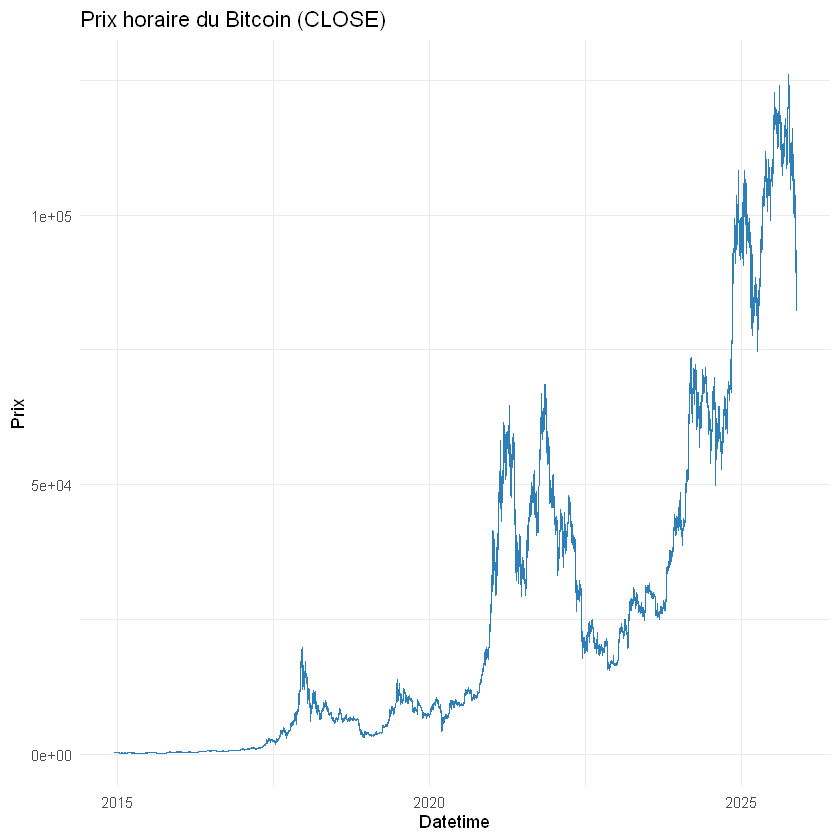

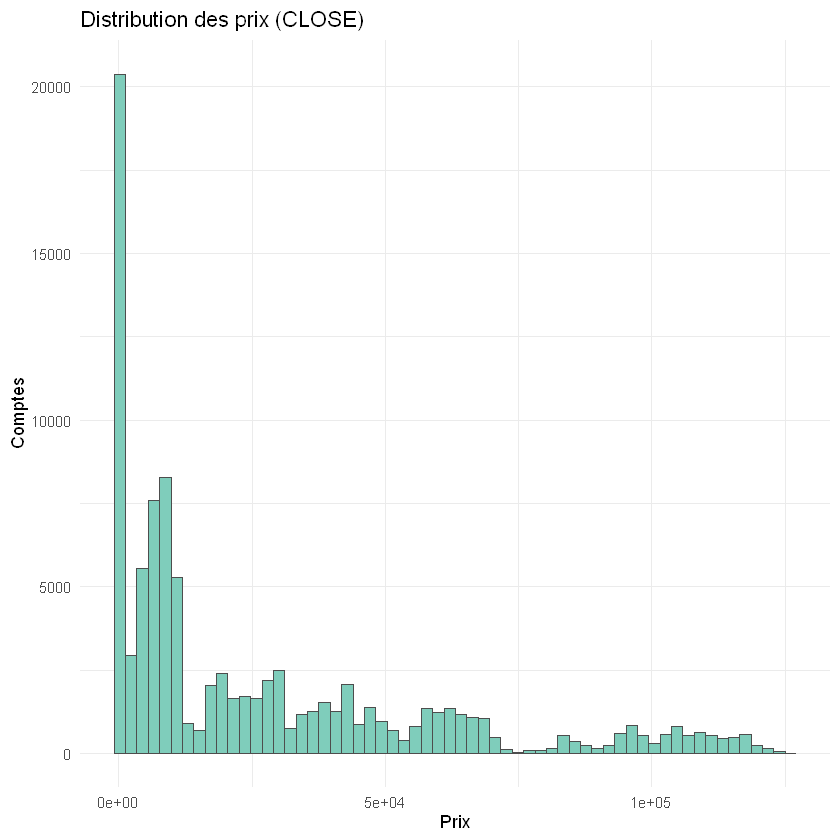

In [11]:
# Acte 1 — Diagrammes: prix vs temps, histogramme des prix

stopifnot(all(c("datetime","close") %in% names(dt)))



p1 <- ggplot(dt, aes(x = datetime, y = close)) +

  geom_line(color = "#2C7FB8", linewidth = 0.3) +

  labs(title = "Prix horaire du Bitcoin (CLOSE)", x = "Datetime", y = "Prix") +

  theme_minimal()



p2 <- ggplot(dt, aes(x = close)) +

  geom_histogram(bins = 60, fill = "#7FCDBB", color = "grey30") +

  labs(title = "Distribution des prix (CLOSE)", x = "Prix", y = "Comptes") +

  theme_minimal()



p1

p2


## 🎬 Acte 2 — La volatilité : l'ADN du Bitcoin

Message: La volatilité est une constante, mais son intensité change selon les périodes.

Objectifs:
- Moyenne & max de ATR et VOLATILITY_30D
- Comparaison volatilité early years vs recent years

Diagrammes:
- VOLATILITY_30D dans le temps
- Boxplot de la volatilité par année
- Histogramme de PRICE_VOLATILITY_30D


In [12]:
# Acte 2 — Statistiques volatilité
has_atr <- "ATR" %in% names(dt)
has_vol <- "VOLATILITY_30D" %in% names(dt)

if (has_atr) {
  atr_mean <- mean(dt$ATR, na.rm = TRUE)
  atr_max <- max(dt$ATR, na.rm = TRUE)
  cat("ATR moyen: ", signif(atr_mean, 4), ", max: ", signif(atr_max, 4), "\n", sep = "")
} else {
  cat("ATR non disponible (besoin OHLC)\n")
}

if (has_vol) {
  vol_mean <- mean(dt$VOLATILITY_30D, na.rm = TRUE)
  vol_max <- max(dt$VOLATILITY_30D, na.rm = TRUE)
  cat("VOLATILITY_30D moyen: ", signif(vol_mean, 4), ", max: ", signif(vol_max, 4), "\n", sep = "")
  
  # Early vs recent: couper en 2
  if ("datetime" %in% names(dt)) {
    dt_clean <- dt %>% filter(!is.na(VOLATILITY_30D), !is.na(datetime))
    mid_date <- median(dt_clean$datetime, na.rm = TRUE)
    early <- dt_clean %>% filter(datetime < mid_date)
    recent <- dt_clean %>% filter(datetime >= mid_date)
    cat("Volatilité early years (moy): ", signif(mean(early$VOLATILITY_30D, na.rm = TRUE), 4), "\n", sep = "")
    cat("Volatilité recent years (moy): ", signif(mean(recent$VOLATILITY_30D, na.rm = TRUE), 4), "\n", sep = "")
  }
} else {
  cat("VOLATILITY_30D non disponible\n")
}


ATR moyen: 203.9, max: 2166
VOLATILITY_30D moyen: 0.006807, max: 0.02
Volatilité early years (moy): 0.007643
Volatilité recent years (moy): 0.005971


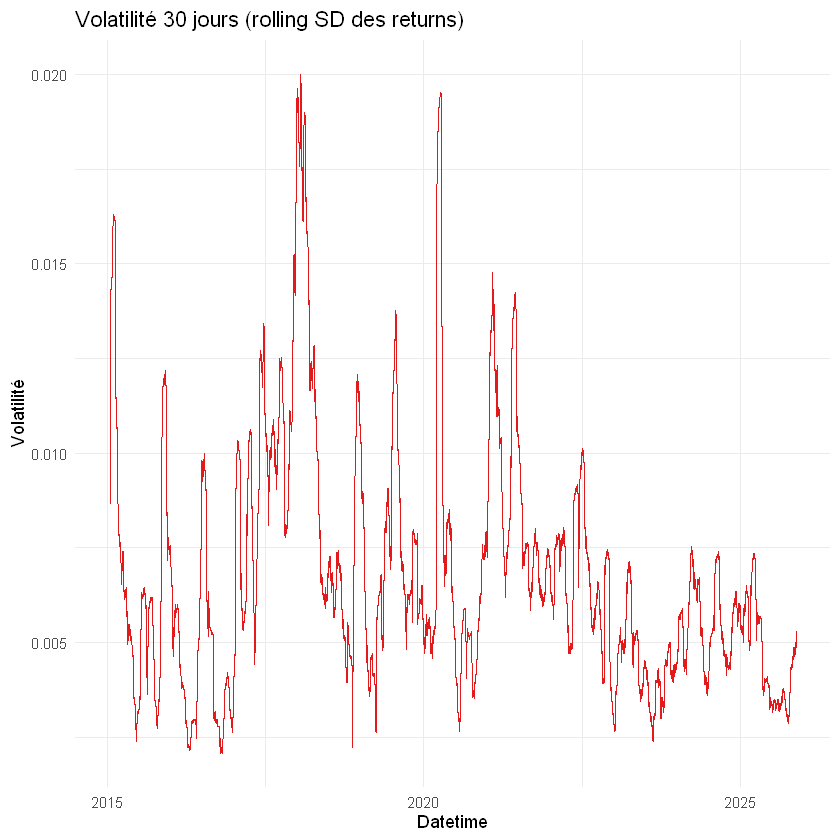

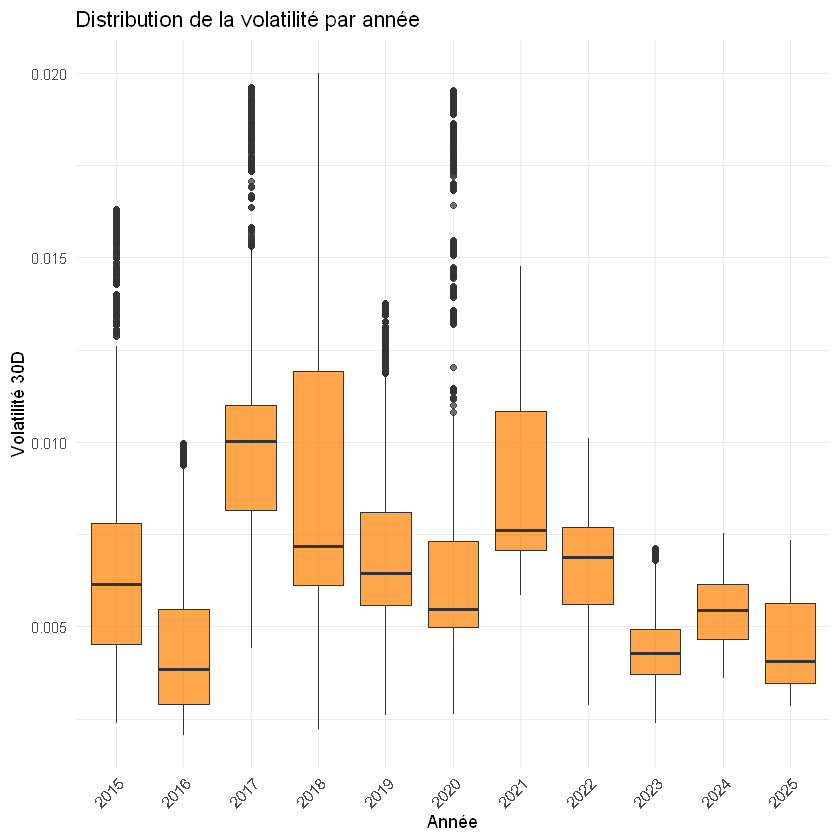

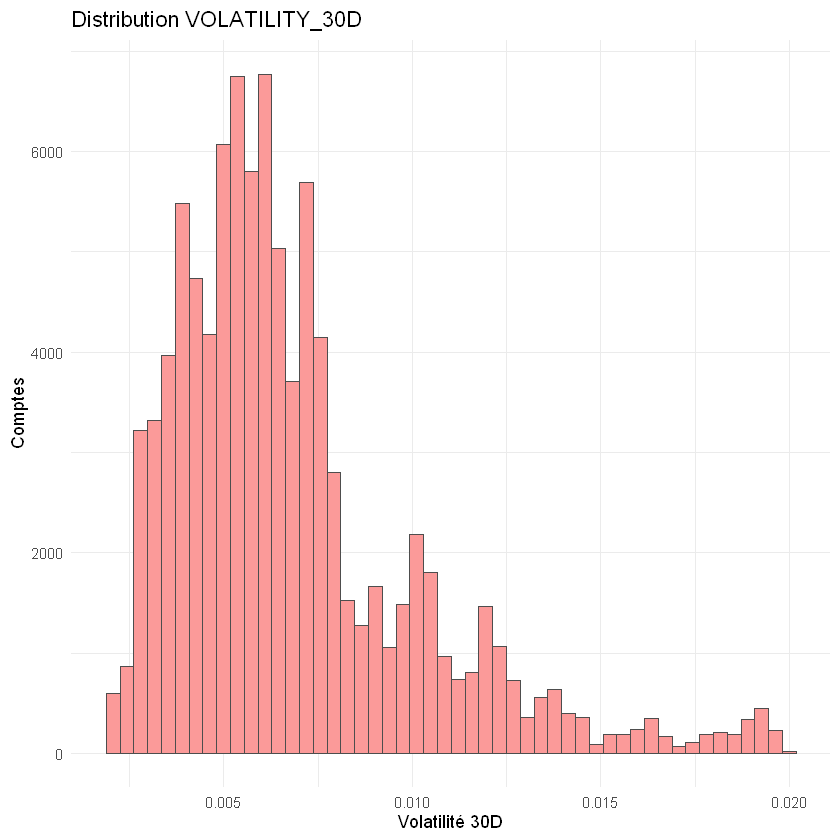

In [13]:
# Acte 2 — Diagrammes volatilité
if ("VOLATILITY_30D" %in% names(dt) && "datetime" %in% names(dt)) {
  dt_clean <- dt %>% filter(!is.na(VOLATILITY_30D), !is.na(datetime))
  
  # Time series
  p1 <- ggplot(dt_clean, aes(x = datetime, y = VOLATILITY_30D)) +
    geom_line(color = "#E31A1C", linewidth = 0.4) +
    labs(title = "Volatilité 30 jours (rolling SD des returns)", x = "Datetime", y = "Volatilité") +
    theme_minimal()
  
  # Boxplot par année
  dt_clean <- dt_clean %>% mutate(year = lubridate::year(datetime))
  p2 <- ggplot(dt_clean, aes(x = factor(year), y = VOLATILITY_30D)) +
    geom_boxplot(fill = "#FF7F00", alpha = 0.7) +
    labs(title = "Distribution de la volatilité par année", x = "Année", y = "Volatilité 30D") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
  # Histogramme
  p3 <- ggplot(dt_clean, aes(x = VOLATILITY_30D)) +
    geom_histogram(bins = 50, fill = "#FB9A99", color = "grey30") +
    labs(title = "Distribution VOLATILITY_30D", x = "Volatilité 30D", y = "Comptes") +
    theme_minimal()
  
  print(p1)
  print(p2)
  print(p3)
} else {
  cat("VOLATILITY_30D ou datetime manquant.\n")
}


## 🎬 Acte 3 — Le volume : quand le marché s'emballe

Message: Le volume raconte l'histoire des crises et des bull runs.

Objectifs:
- Volume moyen / médian
- Top 1% des volumes horaires
- Corrélation VOLUME ↔ PRICE_CHANGE

Diagrammes:
- VOLUME vs DATETIME
- Scatter : VOLUME vs |PRICE_CHANGE|
- VOLUME_SMA superposé au prix


In [14]:
# Acte 3 — Statistiques volume
if ("volume" %in% names(dt)) {
  vol_mean <- mean(dt$volume, na.rm = TRUE)
  vol_median <- median(dt$volume, na.rm = TRUE)
  vol_q99 <- quantile(dt$volume, 0.99, na.rm = TRUE)
  cat("Volume moyen: ", prettyNum(vol_mean, big.mark = " "), "\n", sep = "")
  cat("Volume médian: ", prettyNum(vol_median, big.mark = " "), "\n", sep = "")
  cat("Top 1% volumes (>= quantile 99%): ", prettyNum(vol_q99, big.mark = " "), "\n", sep = "")
  
  if ("PRICE_CHANGE" %in% names(dt)) {
    dt_clean <- dt %>% filter(!is.na(volume), !is.na(PRICE_CHANGE))
    if (nrow(dt_clean) > 2) {
      corr <- cor(dt_clean$volume, abs(dt_clean$PRICE_CHANGE), use = "complete.obs")
      cat("Corrélation VOLUME ↔ |PRICE_CHANGE|: ", signif(corr, 3), "\n", sep = "")
    }
  }
} else {
  cat("Colonne VOLUME absente.\n")
}


Volume moyen: 39 089 515
Volume médian: 15 739 797
Top 1% volumes (>= quantile 99%): 337 754 550
Corrélation VOLUME ↔ |PRICE_CHANGE|: 0.253


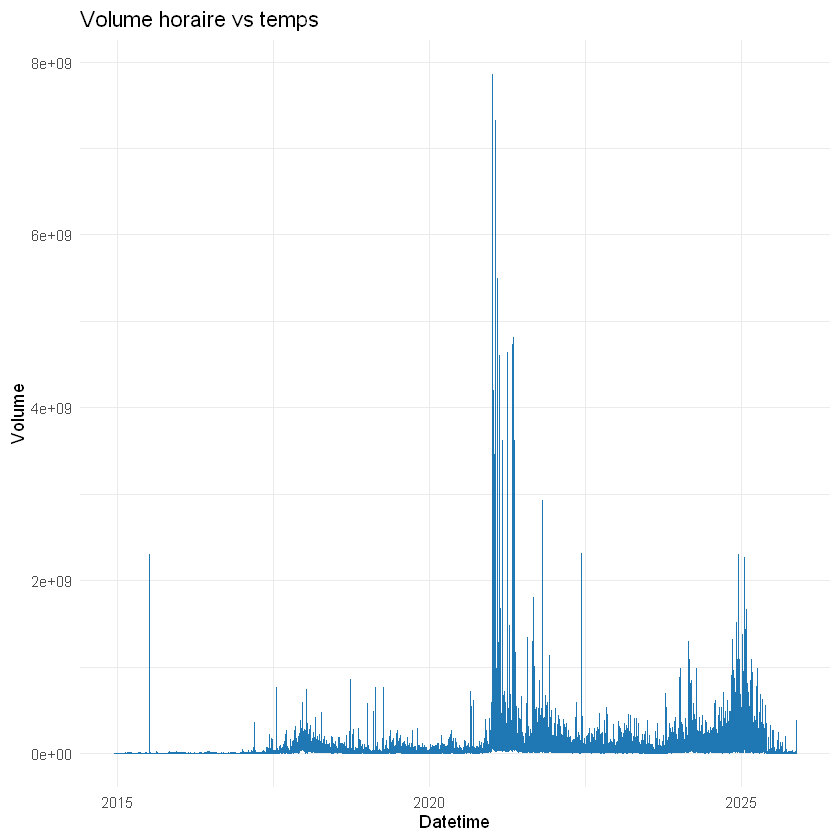

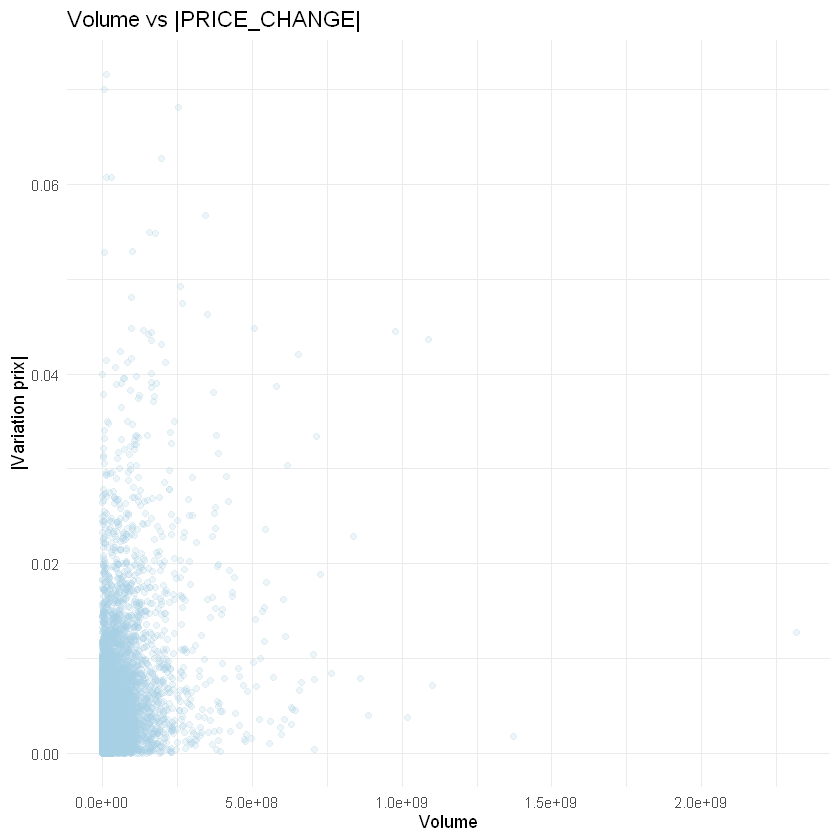

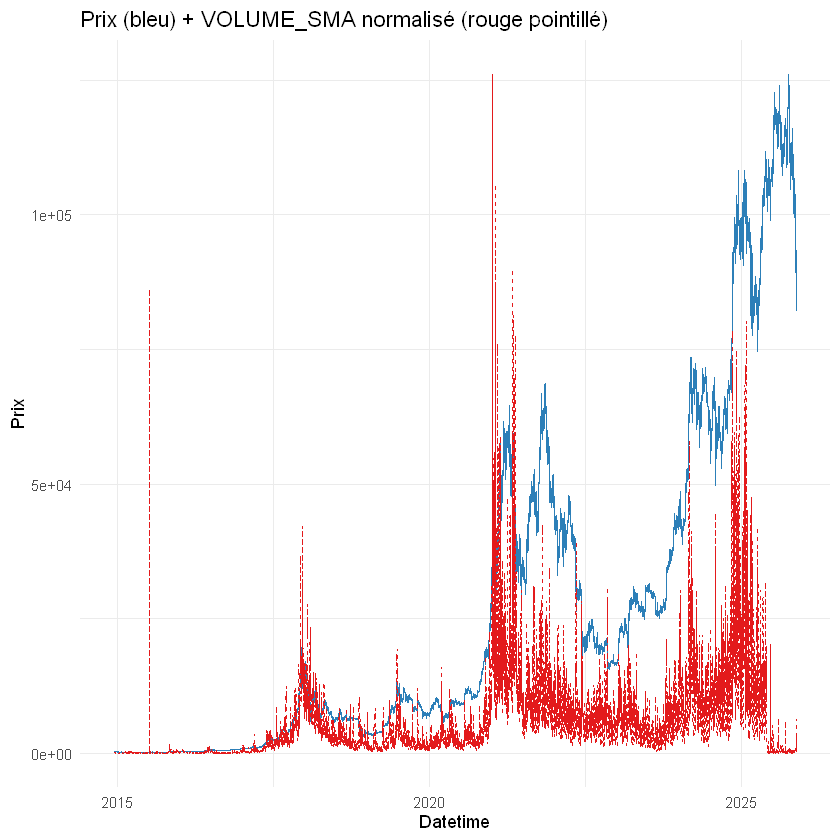

In [15]:
# Acte 3 — Diagrammes volume
if ("volume" %in% names(dt) && "datetime" %in% names(dt)) {
  dt_clean <- dt %>% filter(!is.na(volume), !is.na(datetime))
  
  # Time series volume
  p1 <- ggplot(dt_clean, aes(x = datetime, y = volume)) +
    geom_line(color = "#1F78B4", linewidth = 0.3) +
    labs(title = "Volume horaire vs temps", x = "Datetime", y = "Volume") +
    theme_minimal()
  
  # Scatter volume vs |PRICE_CHANGE|
  if ("PRICE_CHANGE" %in% names(dt)) {
    dt_clean2 <- dt_clean %>% filter(!is.na(PRICE_CHANGE)) %>%
      mutate(abs_change = abs(PRICE_CHANGE))
    p2 <- ggplot(dt_clean2 %>% sample_n(min(10000, nrow(dt_clean2))), 
                 aes(x = volume, y = abs_change)) +
      geom_point(alpha = 0.2, color = "#A6CEE3") +
      labs(title = "Volume vs |PRICE_CHANGE|", x = "Volume", y = "|Variation prix|") +
      theme_minimal()
  } else {
    p2 <- NULL
  }
  
  # VOLUME_SMA overlay sur prix
  if (all(c("VOLUME_SMA","close") %in% names(dt))) {
    dt_clean3 <- dt_clean %>% filter(!is.na(VOLUME_SMA), !is.na(close))
    p3 <- ggplot(dt_clean3, aes(x = datetime)) +
      geom_line(aes(y = close), color = "#2C7FB8", linewidth = 0.4) +
      geom_line(aes(y = VOLUME_SMA/max(VOLUME_SMA, na.rm = TRUE)*max(close, na.rm = TRUE)), 
                color = "#E31A1C", linewidth = 0.4, linetype = "dashed") +
      labs(title = "Prix (bleu) + VOLUME_SMA normalisé (rouge pointillé)", x = "Datetime", y = "Prix") +
      theme_minimal()
  } else {
    p3 <- NULL
  }
  
  print(p1)
  if (!is.null(p2)) print(p2)
  if (!is.null(p3)) print(p3)
} else {
  cat("Volume ou datetime manquant.\n")
}


## 🎬 Acte 4 — Momentum & psychologie du marché

Message: Les indicateurs traduisent les émotions du marché.

Objectifs:
- RSI moyen
- % du temps : RSI > 70 (surachat) et RSI < 30 (survente)

Diagrammes:
- RSI dans le temps avec seuils 30/70
- Histogramme RSI
- STOCH_K / STOCH_D


In [16]:
# Acte 4 — Statistiques momentum (RSI)
if ("RSI" %in% names(dt)) {
  rsi_mean <- mean(dt$RSI, na.rm = TRUE)
  rsi_over70 <- mean(dt$RSI > 70, na.rm = TRUE) * 100
  rsi_under30 <- mean(dt$RSI < 30, na.rm = TRUE) * 100
  cat("RSI moyen: ", signif(rsi_mean, 4), "\n", sep = "")
  cat("% temps RSI > 70 (surachat): ", signif(rsi_over70, 3), "%\n", sep = "")
  cat("% temps RSI < 30 (survente): ", signif(rsi_under30, 3), "%\n", sep = "")
} else {
  cat("RSI non disponible (besoin colonne CLOSE).\n")
}


RSI moyen: 51.1
% temps RSI > 70 (surachat): 6.42%
% temps RSI < 30 (survente): 4.64%


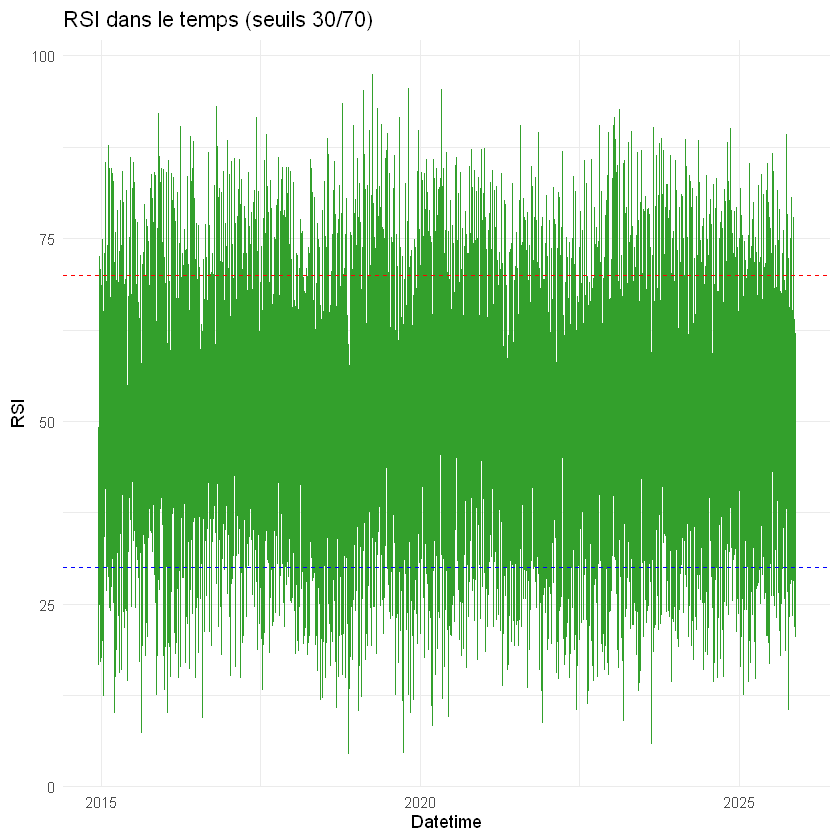

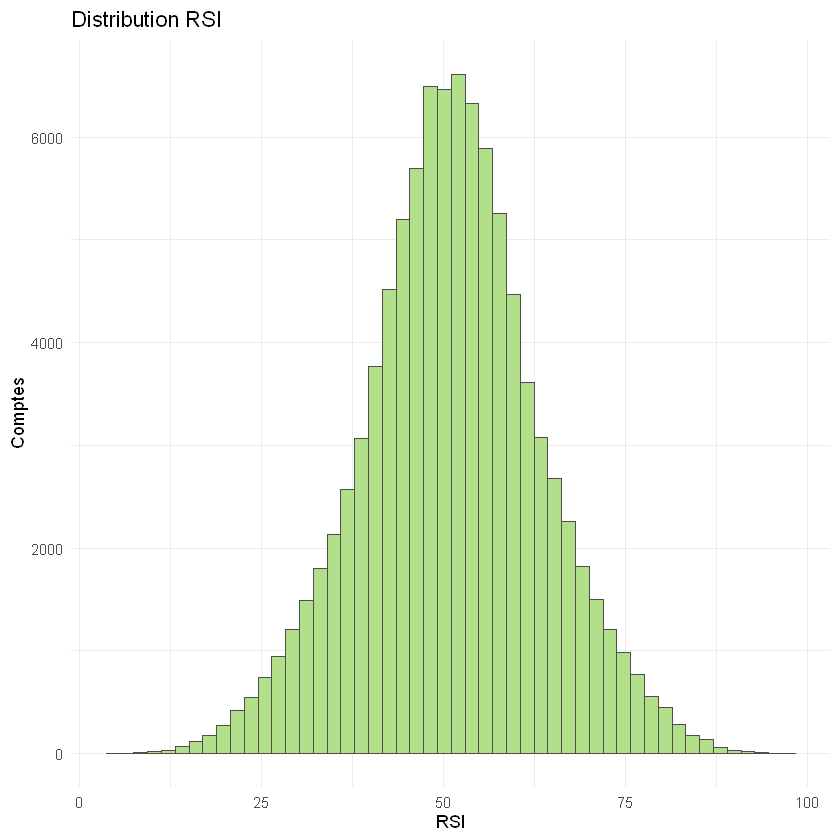

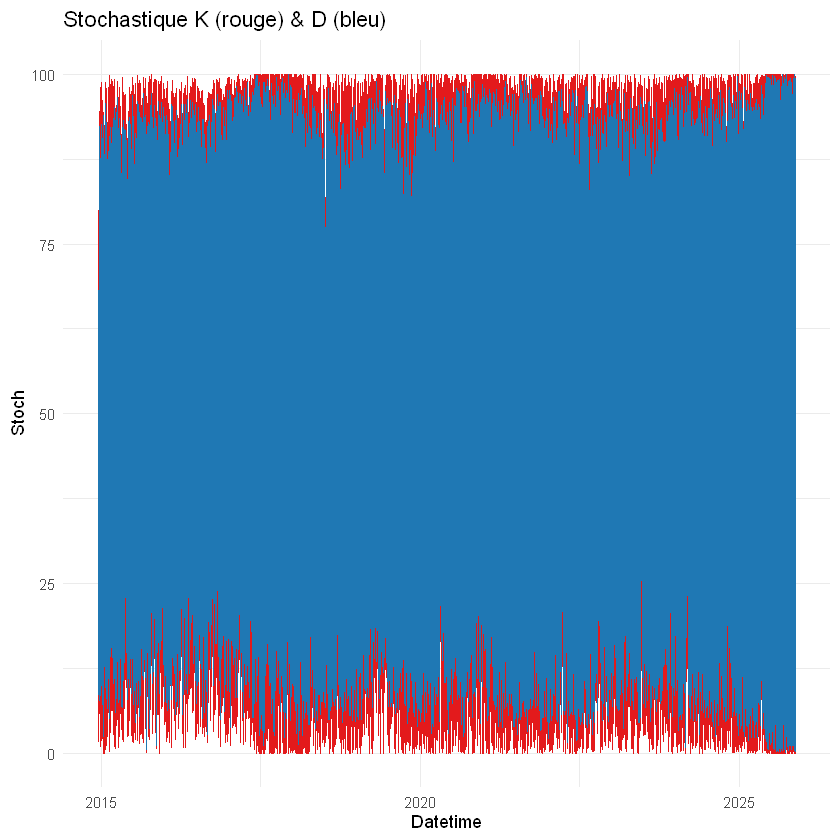

In [17]:
# Acte 4 — Diagrammes momentum
if ("RSI" %in% names(dt) && "datetime" %in% names(dt)) {
  dt_clean <- dt %>% filter(!is.na(RSI), !is.na(datetime))
  
  # RSI time series avec seuils
  p1 <- ggplot(dt_clean, aes(x = datetime, y = RSI)) +
    geom_line(color = "#33A02C", linewidth = 0.3) +
    geom_hline(yintercept = 70, color = "red", linetype = "dashed") +
    geom_hline(yintercept = 30, color = "blue", linetype = "dashed") +
    labs(title = "RSI dans le temps (seuils 30/70)", x = "Datetime", y = "RSI") +
    theme_minimal()
  
  # Histogramme RSI
  p2 <- ggplot(dt_clean, aes(x = RSI)) +
    geom_histogram(bins = 50, fill = "#B2DF8A", color = "grey30") +
    labs(title = "Distribution RSI", x = "RSI", y = "Comptes") +
    theme_minimal()
  
  print(p1)
  print(p2)
} else {
  cat("RSI ou datetime manquant.\n")
}

# Stochastique
if (all(c("STOCH_K","STOCH_D","datetime") %in% names(dt))) {
  dt_clean <- dt %>% filter(!is.na(STOCH_K), !is.na(STOCH_D), !is.na(datetime))
  p3 <- ggplot(dt_clean, aes(x = datetime)) +
    geom_line(aes(y = STOCH_K), color = "#E31A1C", linewidth = 0.3) +
    geom_line(aes(y = STOCH_D), color = "#1F78B4", linewidth = 0.3) +
    labs(title = "Stochastique K (rouge) & D (bleu)", x = "Datetime", y = "Stoch") +
    theme_minimal()
  print(p3)
} else {
  cat("STOCH_K/D non disponibles.\n")
}


## 🎬 Acte 5 — Tendances & régimes de marché

Message: Bitcoin alterne entre tendance et range.

Objectifs:
- % du temps : CLOSE > SMA_20
- % du temps : EMA_12 > EMA_26

Diagrammes:
- CLOSE + SMA_20
- EMA_12 vs EMA_26
- MACD & MACD_SIGNAL


In [18]:
# Acte 5 — Statistiques tendances
if (all(c("close","SMA_20") %in% names(dt))) {
  dt_clean <- dt %>% filter(!is.na(close), !is.na(SMA_20))
  pct_above_sma <- mean(dt_clean$close > dt_clean$SMA_20, na.rm = TRUE) * 100
  cat("% temps CLOSE > SMA_20: ", signif(pct_above_sma, 3), "%\n", sep = "")
} else {
  cat("CLOSE ou SMA_20 manquant.\n")
}

if (all(c("EMA_12","EMA_26") %in% names(dt))) {
  dt_clean <- dt %>% filter(!is.na(EMA_12), !is.na(EMA_26))
  pct_ema_cross <- mean(dt_clean$EMA_12 > dt_clean$EMA_26, na.rm = TRUE) * 100
  cat("% temps EMA_12 > EMA_26: ", signif(pct_ema_cross, 3), "%\n", sep = "")
} else {
  cat("EMA_12 ou EMA_26 manquant.\n")
}


% temps CLOSE > SMA_20: 53.1%
% temps EMA_12 > EMA_26: 54%


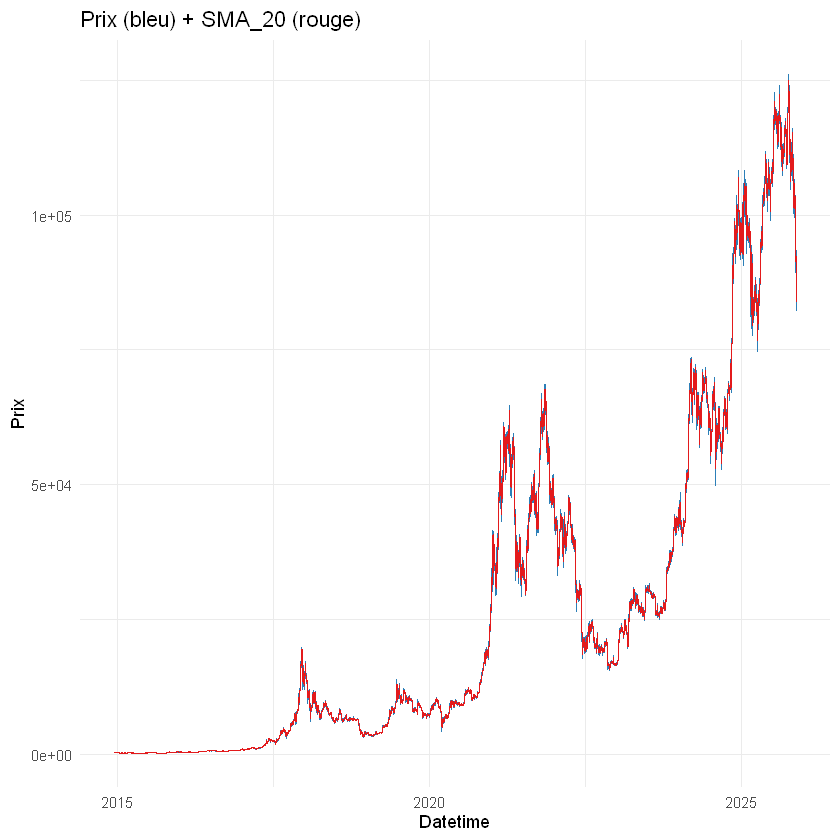

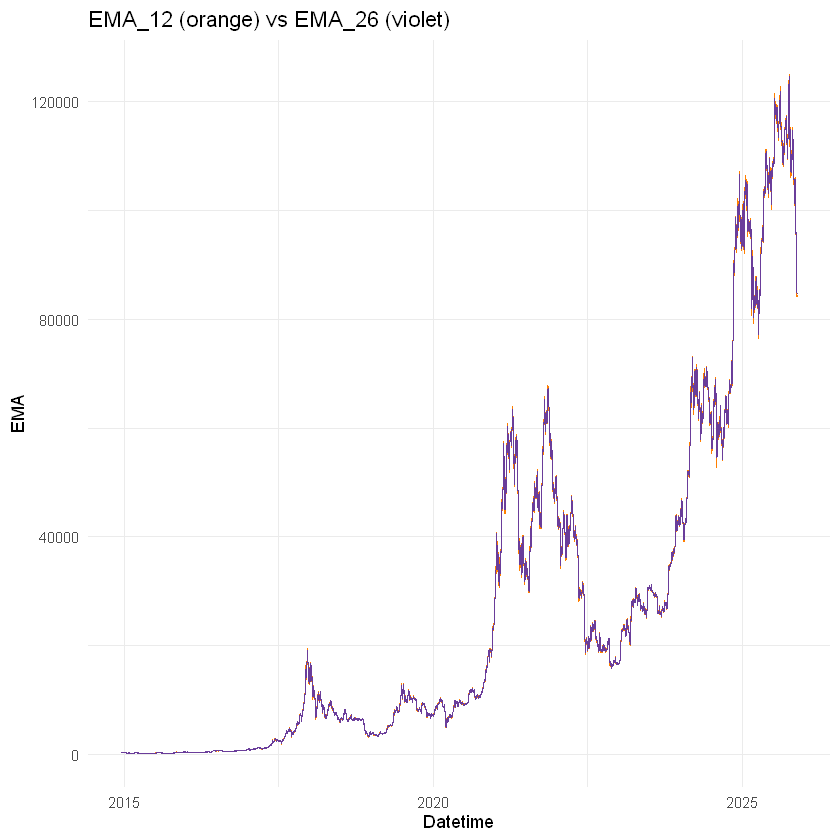

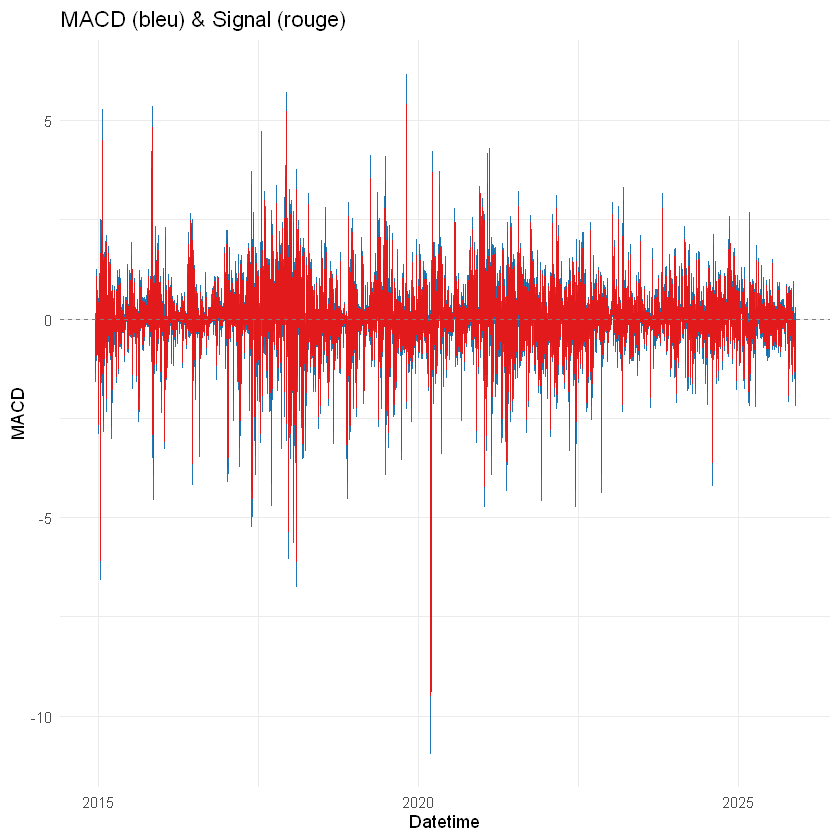

In [19]:
# Acte 5 — Diagrammes tendances
if (all(c("close","SMA_20","datetime") %in% names(dt))) {
  dt_clean <- dt %>% filter(!is.na(close), !is.na(SMA_20), !is.na(datetime))
  p1 <- ggplot(dt_clean, aes(x = datetime)) +
    geom_line(aes(y = close), color = "#2C7FB8", linewidth = 0.3) +
    geom_line(aes(y = SMA_20), color = "#E31A1C", linewidth = 0.4) +
    labs(title = "Prix (bleu) + SMA_20 (rouge)", x = "Datetime", y = "Prix") +
    theme_minimal()
  print(p1)
}

if (all(c("EMA_12","EMA_26","datetime") %in% names(dt))) {
  dt_clean <- dt %>% filter(!is.na(EMA_12), !is.na(EMA_26), !is.na(datetime))
  p2 <- ggplot(dt_clean, aes(x = datetime)) +
    geom_line(aes(y = EMA_12), color = "#FF7F00", linewidth = 0.3) +
    geom_line(aes(y = EMA_26), color = "#6A3D9A", linewidth = 0.3) +
    labs(title = "EMA_12 (orange) vs EMA_26 (violet)", x = "Datetime", y = "EMA") +
    theme_minimal()
  print(p2)
}

if (all(c("MACD","MACD_SIGNAL","datetime") %in% names(dt))) {
  dt_clean <- dt %>% filter(!is.na(MACD), !is.na(MACD_SIGNAL), !is.na(datetime))
  p3 <- ggplot(dt_clean, aes(x = datetime)) +
    geom_line(aes(y = MACD), color = "#1F78B4", linewidth = 0.3) +
    geom_line(aes(y = MACD_SIGNAL), color = "#E31A1C", linewidth = 0.3) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "grey50") +
    labs(title = "MACD (bleu) & Signal (rouge)", x = "Datetime", y = "MACD") +
    theme_minimal()
  print(p3)
}


## 🎬 Acte 6 — Ratios & micro-mouvements

Message: À l'échelle horaire, le marché est très bruité.

Objectifs:
- Moyenne de HIGH_LOW_RATIO
- Distribution de CLOSE_OPEN_RATIO
- Moyenne des PRICE_CHANGE

Diagrammes:
- Histogramme HIGH_LOW_RATIO
- Histogramme PRICE_CHANGE
- Heatmap corrélation features


In [20]:
# Acte 6 — Statistiques ratios & micro-mouvements
if ("HIGH_LOW_RATIO" %in% names(dt)) {
  hlr_mean <- mean(dt$HIGH_LOW_RATIO, na.rm = TRUE)
  cat("HIGH_LOW_RATIO moyen: ", signif(hlr_mean, 4), "\n", sep = "")
}
if ("CLOSE_OPEN_RATIO" %in% names(dt)) {
  cor_mean <- mean(dt$CLOSE_OPEN_RATIO, na.rm = TRUE)
  cor_median <- median(dt$CLOSE_OPEN_RATIO, na.rm = TRUE)
  cat("CLOSE_OPEN_RATIO moyen: ", signif(cor_mean, 4), ", médian: ", signif(cor_median, 4), "\n", sep = "")
}
if ("PRICE_CHANGE" %in% names(dt)) {
  pc_mean <- mean(dt$PRICE_CHANGE, na.rm = TRUE)
  cat("PRICE_CHANGE moyen: ", signif(pc_mean, 4), "\n", sep = "")
}


HIGH_LOW_RATIO moyen: 0.008648
CLOSE_OPEN_RATIO moyen: 8.767e-05, médian: 6.566e-05
PRICE_CHANGE moyen: 8.57e-05


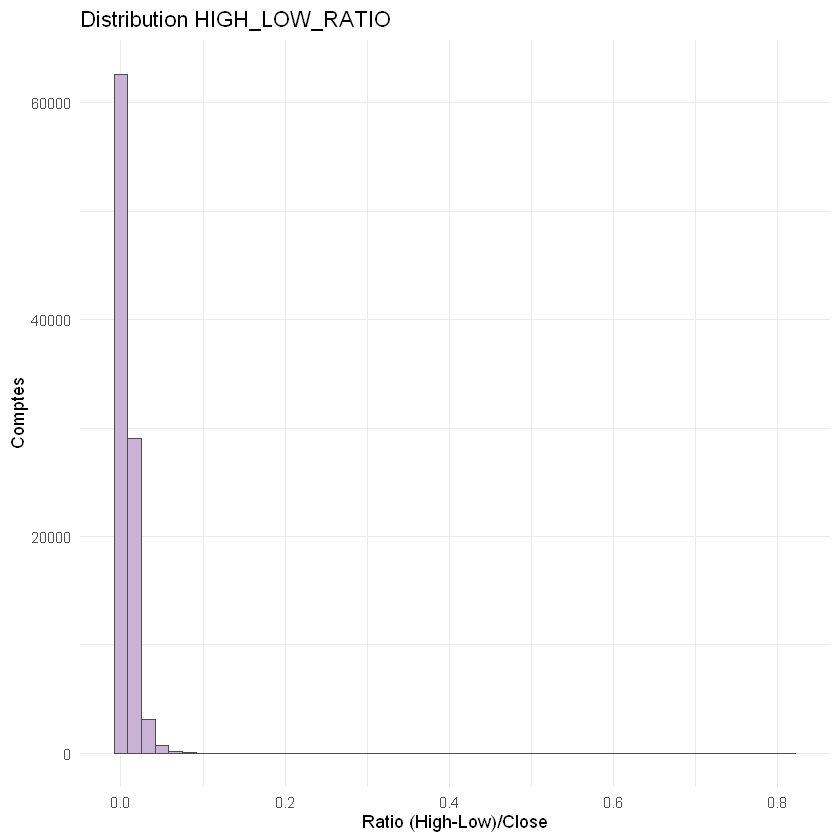

ERROR: Error in select(., all_of(numeric_cols)): argument inutilisé (all_of(numeric_cols))


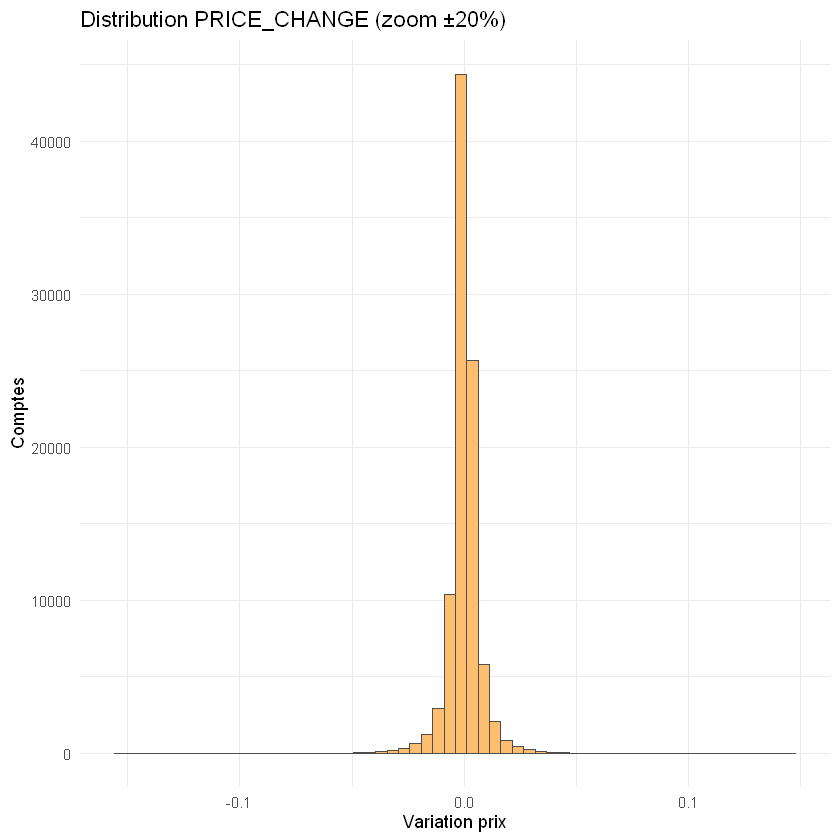

In [21]:
# Acte 6 — Diagrammes ratios & corrélations
if ("HIGH_LOW_RATIO" %in% names(dt)) {
  dt_clean <- dt %>% filter(!is.na(HIGH_LOW_RATIO))
  p1 <- ggplot(dt_clean, aes(x = HIGH_LOW_RATIO)) +
    geom_histogram(bins = 50, fill = "#CAB2D6", color = "grey30") +
    labs(title = "Distribution HIGH_LOW_RATIO", x = "Ratio (High-Low)/Close", y = "Comptes") +
    theme_minimal()
  print(p1)
}

if ("PRICE_CHANGE" %in% names(dt)) {
  dt_clean <- dt %>% filter(!is.na(PRICE_CHANGE), abs(PRICE_CHANGE) < 0.2)  # zoom ±20%
  p2 <- ggplot(dt_clean, aes(x = PRICE_CHANGE)) +
    geom_histogram(bins = 60, fill = "#FDBF6F", color = "grey30") +
    labs(title = "Distribution PRICE_CHANGE (zoom ±20%)", x = "Variation prix", y = "Comptes") +
    theme_minimal()
  print(p2)
}

# Heatmap corrélation (features numériques clés)
numeric_cols <- intersect(names(dt), c("close","volume","ATR","RSI","VOLATILITY_30D","PRICE_CHANGE","HIGH_LOW_RATIO","CLOSE_OPEN_RATIO"))
if (length(numeric_cols) >= 2) {
  dt_cor <- dt %>% select(all_of(numeric_cols)) %>% na.omit()
  if (nrow(dt_cor) > 10) {
    cor_mat <- cor(dt_cor, use = "complete.obs")
    cor_tidy <- as.data.frame(as.table(cor_mat))
    names(cor_tidy) <- c("Var1","Var2","Correlation")
    
    p3 <- ggplot(cor_tidy, aes(x = Var1, y = Var2, fill = Correlation)) +
      geom_tile() +
      scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
      labs(title = "Heatmap corrélation features", x = "", y = "") +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1))
    print(p3)
  }
}


## 🎬 Acte 7 — Synthèse finale

Message final: Bitcoin est un marché hautement non-stationnaire, émotionnel et volatil, mais riche en signaux exploitables.

Récapitulatif:
- Prix : croissance explosive avec phases de stagnation
- Volatilité : constante mais fluctuante, le marché mûrit lentement
- Volume : corrélé aux grands mouvements, indicateur de crises/bull runs
- Momentum : marché passe du temps en zones extrêmes (RSI)
- Tendances : courtes et violentes, alternance tendance/range
- Ratios : le bruit domine à l'échelle horaire → importance du ML et risk management


In [22]:
# Acte 7 — Tableau récapitulatif
summary_stats <- data.frame(
  Dimension = c("Prix", "Volatilité", "Volume", "Momentum"),
  Indicateur_clé = c("CLOSE", "VOLATILITY_30D", "VOLUME", "RSI"),
  Observation = c(
    "Croissance non linéaire avec phases d'explosion et de stagnation",
    "Fluctuante mais constante, le marché mûrit lentement",
    "Corrélé aux grands mouvements de prix, indicateur de crises/bull runs",
    "Le marché passe du temps en zones extrêmes (surachat/survente)"
  )
)

if (requireNamespace("DT", quietly = TRUE)) {
  DT::datatable(summary_stats, options = list(pageLength = 10))
} else {
  print(summary_stats)
}


HTML widgets cannot be represented in plain text (need html)

---

## 🎯 Conclusion

Ce notebook a présenté un storytelling complet des données Bitcoin horaires à travers 7 actes :

1. **Contexte** : Une décennie de croissance explosive
2. **Volatilité** : L'ADN du Bitcoin, constante mais fluctuante
3. **Volume** : Indicateur de crises et bull runs
4. **Momentum** : Psychologie du marché via RSI/Stochastique
5. **Tendances** : Alternance tendance/range, courtes et violentes
6. **Ratios** : Le bruit domine à l'échelle horaire
7. **Synthèse** : Marché non-stationnaire mais riche en signaux

**Stack utilisée :**
- `tidyverse` (dplyr, ggplot2, readr)
- `lubridate` (dates)
- `TTR` (indicateurs techniques)
- `zoo` (rolling windows)
- `patchwork` (composition de plots)
- `DT` (tables interactives)

**Prochaines étapes suggérées :**
- Export des visualisations avec `ggsave()`
- Modélisation ML (Random Forest, XGBoost, LSTM)
- Backtesting de stratégies de trading
- Analyse de séries temporelles (ARIMA, Prophet)
- Rapport Quarto/RMarkdown pour partage

---
